# Regression in PySpark's MLlib Project

Now it's time to put what you've learned to into action with a REAL project! 

You have been hired as a consultant to a cement production company who wants to be able to improve their customer experience around a number of areas like being able to provide recommendations to cusomters on optimal amounts of certian ingredients in the cement making process and perhaps even create an application where users can input their own values and received a predicted cement strength!

I have provided a list of question below to help guide you through this project but feel free to deviate and make this project your own! But first, a bit about this dataset.

### About this dataset 
This dataset contains 1030 instances of concrete samples, containing 9 attributes (8 continuous and 1 discreate), and 1 continuous quantitative output variable. There are no missing attribute values.

### Attribute Information:

Given are the variable name, variable type, the measurement unit and a brief description. The concrete compressive strength is the outcome variable. The order of this listing corresponds to the order of numerals along the rows of the database.

Name -- Data Type -- Measurement -- Description

- Cement -- quantitative -- kg in a m3 mixture -- Input Variable 
- Blast Furnace Slag -- quantitative -- kg in a m3 mixture -- Input Variable 
- Fly Ash -- quantitative -- kg in a m3 mixture -- Input Variable 
- Water -- quantitative -- kg in a m3 mixture -- Input Variable 
- Superplasticizer -- quantitative -- kg in a m3 mixture -- Input Variable 
- Coarse Aggregate -- quantitative -- kg in a m3 mixture -- Input Variable 
- Fine Aggregate -- quantitative -- kg in a m3 mixture -- Input Variable 
- Age -- quantitative -- Day (1~365) -- Input Variable 
- Concrete compressive strength -- quantitative -- MPa -- Output Variable

**Source:** https://www.kaggle.com/maajdl/yeh-concret-data

**Dataset Name:** Concrete_Data.csv

In [1]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession


spark = SparkSession.builder.appName("Regression_Project").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()

print("You are working with", cores, "core(s)")

spark

You are working with 1 core(s)


**Let's start by reading in our datasets**

In [2]:
path =""
df = spark.read.csv(path+'Concrete_Data.csv',inferSchema=True,header=True)

**View data**

In [3]:
df.limit(6).toPandas()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.03


**And of course the schema :)**

In [4]:
df.printSchema()

root
 |-- cement: double (nullable = true)
 |-- slag: double (nullable = true)
 |-- flyash: double (nullable = true)
 |-- water: double (nullable = true)
 |-- superplasticizer: double (nullable = true)
 |-- coarseaggregate: double (nullable = true)
 |-- fineaggregate: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- csMPa: double (nullable = true)



**Doulbe check to see if there are any missing values**

In [5]:
#drop missing data
drop = df.na.drop()
print('before dropping missings:',df.count())
print('after dropping missings',drop.count())

before dropping missings: 1030
after dropping missings 1030


## 1. Which features are the strongest predictors of cement strength?

Build your own ML model to figure this one out! This would be good information to give to our client so the sales reps can focus their efforts on certian ingredients to provide recommendations on. For example, if our clients had a customer that was struggling with their cement breaking, we could trouble shoot with them by starting with the factors that we know are important.

So in order to do this, we first need to format our data and create a model!

In [8]:
def MLRegressDFPrep(df,input_columns,dependent_var,treat_outliers=True,treat_neg_values=True):
    
    # rename dependent variable as label for pyspark
    renamed = df.withColumnRenamed(dependent_var,'label')
    
    # make sure dependent variable is numeric and change if it's not
    if str(renamed.schema['label'].dataType) != 'IntegerType':
        renamed = renamed.withColumn("label", renamed["label"].cast(FloatType()))
    
   # convert all string type data in the input column list to numeric


    numeric_inputs = []
    string_inputs = []
    for column in input_columns:
        if str(renamed.schema[column].dataType) == 'StringType':
            new_col_name = column+"_num"
            string_inputs.append(new_col_name)
        else:
            numeric_inputs.append(column)
            indexed = renamed
            
    if len(string_inputs) != 0: # If the datafraem contains string types
        for column in input_columns:
            if str(renamed.schema[column].dataType) == 'StringType':
                indexer = StringIndexer(inputCol=column, outputCol=column+"_num") 
                indexed = indexer.fit(renamed).transform(renamed)
    else:
        indexed = renamed
        
            
    if treat_outliers == True:
        # empty dictionary d
        d = {}
        # Create a dictionary of quantiles
        for col in numeric_inputs: 
            d[col] = indexed.approxQuantile(col,[0.01,0.99],0.25) 
        for col in numeric_inputs:
            skew = indexed.agg(skewness(indexed[col])).collect() #check for skewness
            skew = skew[0][0]
            # This function will floor, cap and then log+1 (just in case there are 0 values)
            if skew > 1:
                indexed = indexed.withColumn(col, \
                log(when(df[col] < d[col][0],d[col][0])\
                .when(indexed[col] > d[col][1], d[col][1])\
                .otherwise(indexed[col] ) +1).alias(col))

            elif skew < -1:
                indexed = indexed.withColumn(col, \
                exp(when(df[col] < d[col][0],d[col][0])\
                .when(indexed[col] > d[col][1], d[col][1])\
                .otherwise(indexed[col] )).alias(col))
            
    features_list = numeric_inputs + string_inputs
    assembler = VectorAssembler(inputCols=features_list,outputCol='features')
    output = assembler.transform(indexed).select('features','label')

#     final_data = output.select('features','label') #drop everything else
    
    if treat_neg_values == True:
        scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

        # Compute summary statistics and generate MinMaxScalerModel
        global scalerModel
        scalerModel = scaler.fit(output)

        # rescale each feature to range [min, max].
        scaled_data = scalerModel.transform(output)
        final_data = scaled_data.select('label','scaledFeatures')
        final_data = final_data.withColumnRenamed('scaledFeatures','features')
    
    else:
        final_data = output
    
    return final_data

In [9]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import * 
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import MinMaxScaler

input_columns = df.columns[:-1] # all except the last one
dependent_var = df.columns[-1] # The last column

final_data = MLRegressDFPrep(df,input_columns,dependent_var)
final_data.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|79.99|[1.0,0.0,0.0,0.32...|
|61.89|[1.0,0.0,0.0,0.32...|
|40.27|[0.52625570776255...|
|41.05|[0.52625570776255...|
| 44.3|[0.22054794520547...|
+-----+--------------------+
only showing top 5 rows



## Check for Multicollinearity

Let's make sure we don't have any multicollinearity before we go any further. Remeber the following guidelines for pearson's:

- .00-.19 (very weak)
- .20-.39 (weak)
- .40-.59 (moderate)
- .60-.79 (strong)
- .80-1.0 (very strong)

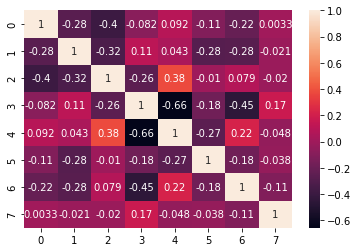

In [19]:
from pyspark.ml.stat import Correlation
pearsonCorr = Correlation.corr(final_data, 'features', 'pearson').collect()

import seaborn as sns
sns.heatmap(pearsonCorr[0][0].toArray(), annot=True)

array = pearsonCorr[0][0].toArray()

## Split dataframe into training and evaluation (test)

I'm going with 70/30 but you can use your own mix if you want. 

In [21]:
train,test = final_data.randomSplit([0.7,0.3])

In [37]:
def RegressTrainEval(regressor):

    def FindMtype(regressor):
        # Intstantiate Model
        M = regressor
        # Learn what it is
        Mtype = type(M).__name__
        
        return Mtype
    
    Mtype = FindMtype(regressor)
#     print('\033[1m' + Mtype + ':' + '\033[0m')


    if Mtype == "LinearRegression":
        
        #first without cross val
        fitModel = regressor.fit(train)

        # Load the Summary
        trainingSummary = fitModel.summary
        
        # Print the coefficients and intercept for linear regression
        print("Linear Regression Model Summary without cross validation:")
        print(" ")
        print("Coefficients: %s" % str(fitModel.coefficients))
        print("Intercept: %s" % str(fitModel.intercept))
        print("")

        # Summarize the model over the training set and print out some metrics
        print("numIterations: %d" % trainingSummary.totalIterations)
        print("objectiveHistory: (scaled loss + regularization) at each iteration \n %s" % str(trainingSummary.objectiveHistory))
        print("")
        
        # Print the Errors
        print("Training RMSE: %f" % trainingSummary.rootMeanSquaredError)
        print("Training r2: %f" % trainingSummary.r2)
        print("")
        

        # Now load the test results
        test_results = fitModel.evaluate(test)

        # And print them
        print("Test RMSE: {}".format(test_results.rootMeanSquaredError))
        print("Test r2: {}".format(test_results.r2))
        print("")
        
        #Now train with cross val
        paramGrid = (ParamGridBuilder() \
             .addGrid(regressor.maxIter, [10, 15]) \
             .addGrid(regressor.regParam, [0.1, 0.01]) \
             .build())
        
        #Evaluator
        revaluator = RegressionEvaluator(metricName="rmse")
        
        #Cross Validator requires all of the following parameters:
        crossval = CrossValidator(estimator=regressor,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=revaluator,
                                  numFolds=3) # 3 is best practice
        
        print("Linear Regression Model Summary WITH cross validation:")
        print(" ")
        # Run cross validations
        fitModel = crossval.fit(train)
        
        # Get Model Summary Statistics
        ModelSummary = fitModel.bestModel.summary
        print("Coefficient Standard Errors: " + str(ModelSummary.coefficientStandardErrors))
        print(" ")
        print("P Values: " + str(ModelSummary.pValues)) # Last element is the intercept
        print(" ")
        
        global LR_Pvalues
        LR_Pvalues = ModelSummary.pValues
        
        #save model
        global LR_BestModel 
        LR_BestModel = fitModel.bestModel
        
        # Use test set here so we can measure the accuracy of our model on new data
        ModelPredictions = fitModel.transform(test)
        
        # cvModel uses the best model found from the Cross Validation
        # Evaluate best model
        test_results = revaluator.evaluate(ModelPredictions)
        print('RMSE:', test_results)


    else:

        if Mtype in("RandomForestRegressor"):
            paramGrid = (ParamGridBuilder() \
#                            .addGrid(regressor.maxDepth, [2, 5, 10])
#                            .addGrid(regressor.maxBins, [5, 10, 20])
                           .addGrid(regressor.numTrees, [5, 20,100])
                         .build())

        if Mtype in("GBTRegressor"):
            paramGrid = (ParamGridBuilder() \
#                          .addGrid(regressor.maxDepth, [2, 5, 10, 20, 30]) \
#                          .addGrid(regressor.maxBins, [10, 20]) \
                         .addGrid(regressor.maxIter, [10, 15])
                         .build())

        if Mtype in("DecisionTreeRegressor"):
            paramGrid = (ParamGridBuilder() \
#                          .addGrid(regressor.maxDepth, [2, 5, 10, 20, 30]) \
                         .addGrid(regressor.maxBins, [10, 20, 40]) \
                         .build())

        crossval = CrossValidator(estimator=regressor,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=RegressionEvaluator(metricName="rmse"),
                                  numFolds=3) 

        fitModel = crossval.fit(train)
        
        BestModel = fitModel.bestModel

        # FEATURE IMPORTANCES
        # Estimate of the importance of each feature.
        # Each feature’s importance is the average of its importance across all trees 
        # in the ensemble The importance vector is normalized to sum to 1. 
        print(" ")
        print('\033[1m' + Mtype," Feature Importances"+ '\033[0m')
        print("(Scores add up to 1)")
        print("Lowest score is the least important")
        print(" ")
        print(BestModel.featureImportances)
        
        #Create Global Variables for feature importances and models
        if Mtype in("DecisionTreeRegressor"):
            global DT_featureimportances
            DT_featureimportances = BestModel.featureImportances.toArray()
            global DT_BestModel 
            DT_BestModel = fitModel.bestModel
        if Mtype in("GBTRegressor"):
            global GBT_featureimportances
            GBT_featureimportances = BestModel.featureImportances.toArray()
            global GBT_BestModel 
            GBT_BestModel = fitModel.bestModel
        if Mtype in("RandomForestRegressor"):
            global RF_featureimportances
            RF_featureimportances = BestModel.featureImportances.toArray()
            global RF_BestModel 
            RF_BestModel = fitModel.bestModel
               
        predictions = fitModel.transform(test)
        # Select (prediction, true label) and compute test error
        evaluator = RegressionEvaluator(metricName="rmse")
        rmse = evaluator.evaluate(predictions)
        print(Mtype+' RMSE Test: ',rmse)
        

**And now run it!**

In [38]:
from pyspark.ml.regression import *
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

RegressTrainEval(LinearRegression())


Linear Regression Model Summary without cross validation:
 
Coefficients: [54.49917214407327,37.71322035601671,16.16750603656825,-18.148760452897463,6.562913392695495,7.699236187163313,10.643633204290317,48.640876055986766]
Intercept: -23.634300728307988

numIterations: 1
objectiveHistory: (scaled loss + regularization) at each iteration 
 [0.0]

Training RMSE: 7.236321
Training r2: 0.802851

Test RMSE: 7.070531149016084
Test r2: 0.8376346253062182

Linear Regression Model Summary WITH cross validation:
 
Coefficient Standard Errors: [3.10020116766023, 3.0286340369315687, 2.0686729515856896, 4.289631888412868, 2.583913942722962, 2.6980944336525274, 3.5843700252669004, 1.2927767596596753, 6.971198483384555]
 
P Values: [0.0, 0.0, 5.906386491005833e-14, 1.6419150540292193e-05, 0.011194706078048844, 0.006615141199125096, 0.004832107210560155, 0.0, 0.0012407226713235797]
 
RMSE: 7.077665577179895


In [39]:
RegressTrainEval(RandomForestRegressor())


 
RandomForestRegressor  Feature Importances
(Scores add up to 1)
Lowest score is the least important
 
(8,[0,1,2,3,4,5,6,7],[0.24285989981909517,0.045034396869401604,0.04195229312754408,0.10546356253942302,0.08323079666616243,0.02299772182477055,0.04116329568123304,0.41729803347236993])
RandomForestRegressor RMSE Test:  7.372555954763336


In [40]:
RegressTrainEval(GBTRegressor())


 
GBTRegressor  Feature Importances
(Scores add up to 1)
Lowest score is the least important
 
(8,[0,1,2,3,4,5,6,7],[0.1591927199267366,0.07727001758853698,0.07880398816940253,0.13891159935048059,0.11672321814632633,0.1284439328500871,0.11694905671920929,0.18370546724922057])
GBTRegressor RMSE Test:  6.841205984506386


In [41]:
RegressTrainEval(DecisionTreeRegressor())

 
DecisionTreeRegressor  Feature Importances
(Scores add up to 1)
Lowest score is the least important
 
(8,[0,1,2,3,4,5,6,7],[0.3769943426245813,0.050488406653913694,0.0048906880047473135,0.08312304713399056,0.0552623213702522,0.00029624965221967264,0.044204146905991545,0.3847407976543037])
DecisionTreeRegressor RMSE Test:  8.907690408419791


In [42]:
n = 4

print('Random Forest best features: ',RF_featureimportances.argsort()[-n:][::-1])
print('GBT best features: ',GBT_featureimportances.argsort()[-n:][::-1])
print('Decision Tree best features: ',DT_featureimportances.argsort()[-n:][::-1])
print('Linear Regression best features: ',LR_Pvalues)

Random Forest best features:  [7 0 3 4]
GBT best features:  [7 0 3 5]
Decision Tree best features:  [7 0 3 4]
Linear Regression best features:  [0.0, 0.0, 5.906386491005833e-14, 1.6419150540292193e-05, 0.011194706078048844, 0.006615141199125096, 0.004832107210560155, 0.0, 0.0012407226713235797]


##  For the following given inputs, what would be the estimated cement strength?

- Cement: 540
- Blast Furnace Slag: 0
- Fly Ash: 0
- Water: 162
- Superplasticizer: 2.5
- Coarse Aggregate: 1040
- Fine Aggregate: 676
- Age: 28

The correct answer according to my model is 79.99. Let's see what you get!

In [48]:
# Manually input our values from above.

test = df.limit(1)

test = test.withColumn("age", log("age") +1)

features_list = ["cement","slag","flyash","water","superplasticizer","coarseaggregate","fineaggregate","age"]
assembler = VectorAssembler(inputCols=features_list,outputCol='features')
test = assembler.transform(test).select('features')

scaled_test = scalerModel.transform(test)
final_test = scaled_test.select('scaledFeatures')
final_test = final_test.withColumnRenamed('scaledFeatures','features')

predictions = LR_BestModel.transform(final_test)
predictions.show()


+--------------------+-----------------+
|            features|       prediction|
+--------------------+-----------------+
|[1.0,0.0,0.0,0.32...|67.07166264875723|
+--------------------+-----------------+

